In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
sns.set_theme(context="poster", font_scale=1)

from pathlib import Path

sys.path.append("/home/acho/Sync/KiddLab/MSM/src")
from utils.stim_tools import *

# sys.path.append("/home/acho/Sync/Python/sigtools")
# from sigtools.representations import *
# from sigtools.sounds import *
# from sigtools.processing import *
# from sigtools.spatialization import *

|| MSM INITIALIZATION
Setting paths...
Importing sigtools...
Setting up sounddevice...
Importing level adjustments...
Setting eligible BUG words...
Set values for tone pattern synthesis...
Initialization complete!


In [2]:
# plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"

In [10]:
stim_data = pd.read_csv(STIM_DIR/"stimulus_database.csv")
conditions = ["colocated", "plus_minus_90", 0.5, 2, 4, 8]
chance_level = 1/8
# runs_to_plot = range(8)
runs_to_plot = range(4)
# runs_to_plot = range(4, 8)

run_storage = pd.DataFrame()
for run_num in runs_to_plot:
    run_file_name = "RUN_" + str(run_num).zfill(3) + ".csv"
    run_storage = run_storage.append(pd.read_csv(DATA_DIR/run_file_name))
merged_data = pd.merge(run_storage, stim_data, how="inner").reset_index(drop=True)

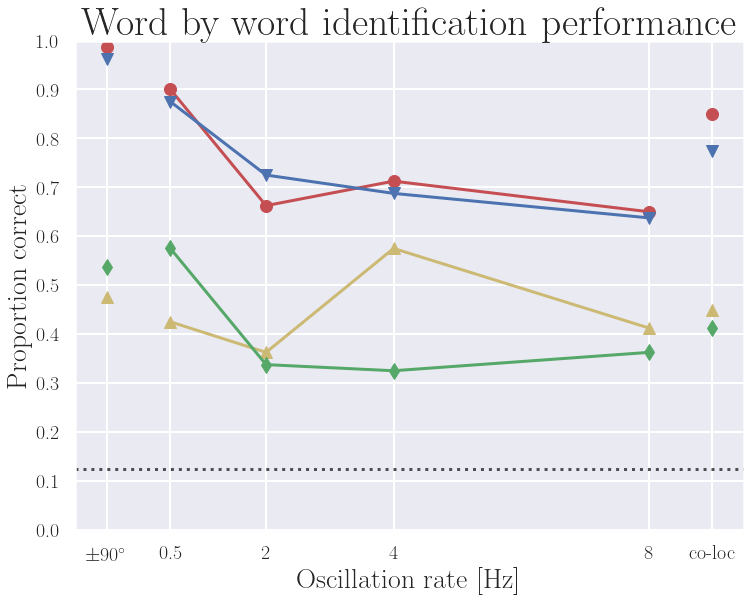

In [12]:
# colors = ["r", "b", "y", "g"]
colors = ["r", "b", "y", "g", "m", "c", "y", "k"]
marker_symbols = ["o", "v", "^", "d", "*", "x", "s", "p"]
x_tick_locs = [-0.5, 9, 0.5, 2, 4, 8]
x_tick_labels = [(r"$\pm90^{\circ}$"), "co-loc", "0.5", "2", "4", "8"]

# legend_elements = []
# for i in range(n_runs_to_load):
#     legend_elements = [Line2D([], [], linestyle="", marker=marker_symbols[i], markeredgewidth=3, markeredgecolor="k", markerfacecolor="w", markersize=18, label=subjects[i])]
# legend_elements.append(Patch(facecolor="b", edgecolor="b", label=r"$\pm 90^{\circ}$"),)
# legend_elements.append(Patch(facecolor="r", edgecolor="r", label=r"$0^{\circ}$"))
# legend_elements.append(Line2D([], [], color="k", linestyle=":", label="chance"))

fig, ax = plt.subplots(1, 1, figsize=(12, 9))

for idx, run_num in enumerate(runs_to_plot):
    curr_run = merged_data[(merged_data["is_target"] == True) &
                           (merged_data["run_num"] == run_num)]
    rate_correct = []
    for cond in conditions:
        if cond == "colocated":
            curr_cond = curr_run[(curr_run["alt_rate"] == 0) &
                                 (curr_run["init_angle"] == 0)]
            n_correct = sum(curr_cond["correct"])
            n_total = 4*len(curr_cond)
            ax.plot(x_tick_locs[1], n_correct/n_total, colors[idx] + marker_symbols[idx])
        elif cond == "plus_minus_90":
            curr_cond = curr_run[(curr_run["alt_rate"] == 0) &
                                 (curr_run["init_angle"] != 0)]
            n_correct = sum(curr_cond["correct"])
            n_total = 4*len(curr_cond)
            ax.plot(x_tick_locs[0], n_correct/n_total, colors[idx] + marker_symbols[idx])
        else:
            curr_cond = curr_run[curr_run["alt_rate"] == cond]
            n_correct = sum(curr_cond["correct"])
            n_total = 4*len(curr_cond)
            rate_correct.append((cond, n_correct/n_total))
    rate_correct = np.array(rate_correct)
    ax.plot(rate_correct[:, 0], rate_correct[:, 1], colors[idx] + marker_symbols[idx] + "-")
ax.hlines(chance_level, x_tick_locs[0] - 0.5, x_tick_locs[1] + 0.5, color="k", linestyle=":", alpha=0.75)

ax.set_title("Word by word identification performance", fontsize=40)
ax.set_xlabel("Oscillation rate [Hz]", fontsize=28)
ax.set_ylabel("Proportion correct", fontsize=28)
ax.set_xlim((x_tick_locs[0] - 0.5, x_tick_locs[1] + 0.5))
ax.set_ylim((0, 1))
ax.set_xticks(x_tick_locs)
ax.set_yticks(np.linspace(0, 1, 11, endpoint=True))
ax.set_xticklabels(x_tick_labels, fontsize=20)
ax.set_yticklabels(np.linspace(0, 1, 11, endpoint=True), fontsize=20)
ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))

ax.grid(linestyle="-")
# ax.legend(handles=legend_elements)

# plt.savefig("ayc_pilot_v3.pdf")
plt.show()

# Plot proportion correct by talker

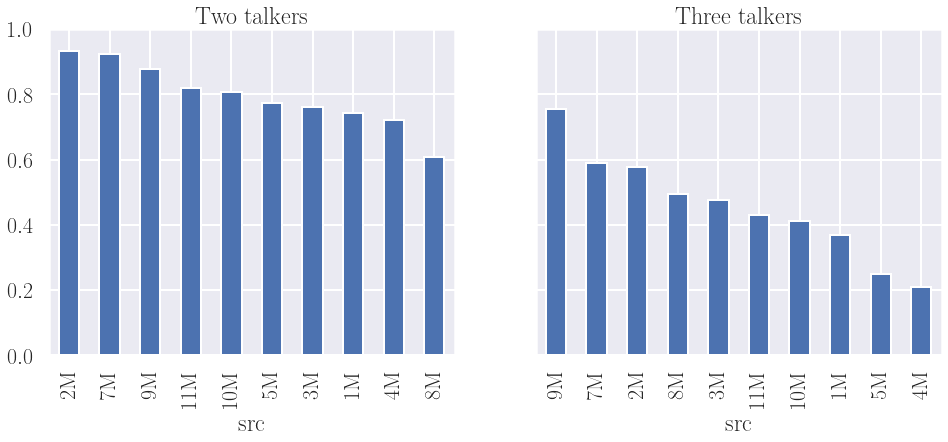

In [9]:
grouped_by_talker_2 = merged_data[(merged_data["is_target"] == True) &
                                  (merged_data["n_srcs"] == 2)].groupby("src").sum("correct")
correct_by_talker_2 = grouped_by_talker_2["correct"]
possible_correct_2 = 4*grouped_by_talker_2["is_target"].values
prop_correct_by_talker_2 = correct_by_talker_2/possible_correct_2
prop_correct_by_talker_2 = prop_correct_by_talker_2.sort_values(ascending=False)

grouped_by_talker_3 = merged_data[(merged_data["is_target"] == True) &
                                  (merged_data["n_srcs"] == 3)].groupby("src").sum("correct")
correct_by_talker_3 = grouped_by_talker_3["correct"]
possible_correct_3 = 4*grouped_by_talker_3["is_target"].values
prop_correct_by_talker_3 = correct_by_talker_3/possible_correct_3
prop_correct_by_talker_3 = prop_correct_by_talker_3.sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
prop_correct_by_talker_2.plot(kind="bar", ylim=(0, 1), ax=axes[0])
prop_correct_by_talker_3.plot(kind="bar", ylim=(0, 1), ax=axes[1])

axes[0].set_title("Two talkers")
axes[1].set_title("Three talkers")
axes[1].set_yticklabels([])

# plt.tight_layout()
plt.show()

# PLOT CONFUSION - MAYBE LISTENER TRACKS TRAJECTORY SO GETS WAY MORE CONFUSED WITH COLOCATED MASKER

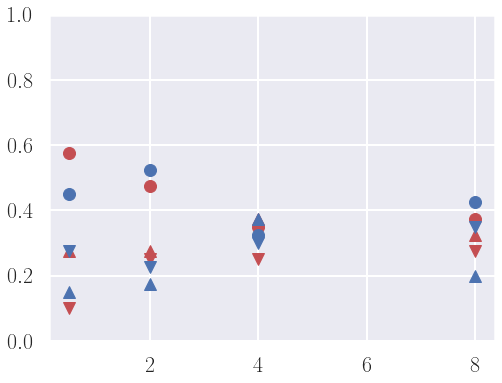

In [13]:
runs = [6, 7]
conditions = [0.5, 2, 4, 8]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for jdx, run_num in enumerate(runs):
    for cond in conditions:
        curr_run = merged_data[(merged_data["run_num"] == run_num) &
                               (merged_data["alt_rate"] == cond)]
        curr_run = curr_run.reset_index()

        all_target_corr = []
        all_confuser_corr = []
        all_distract_corr = []
        try:
            for idx, row in curr_run.iterrows():
                if idx % 3 == 0:
                    response_items = row.subj_response.split(" ")

                    target_items = curr_run.iloc[idx].pattern.split(" ")
                    target_corr = sum([response_items[i] == target_items[i]
                                       for i in range(1, len(response_items))])
                    all_target_corr.append(target_corr/4)

                    distract_items = curr_run.iloc[idx + 1].pattern.split(" ")
                    distract_corr = sum([response_items[i] == distract_items[i]
                                         for i in range(1, len(response_items))])
                    all_distract_corr.append(distract_corr/4)

                    confuser_items = curr_run.iloc[idx + 2].pattern.split(" ")
                    confuser_corr = sum([response_items[i] == confuser_items[i]
                                         for i in range(1, len(response_items))])
                    all_confuser_corr.append(confuser_corr/4)
        except IndexError:
            pass

        target_resp = np.mean(all_target_corr)
        distract_resp = np.mean(all_distract_corr)
        confuser_resp = np.mean(all_confuser_corr)
#         print(target_resp, distract_resp, confuser_resp)
        
        ax.plot(cond, target_resp,   colors[jdx] + "o")
        ax.plot(cond, distract_resp, colors[jdx] + "v")
        ax.plot(cond, confuser_resp, colors[jdx] + "^")

ax.set_ylim((0, 1))

plt.show()

In [ ]:
# run_figsize = (16, 12)
# n_runs_to_load = 1
# n_trials_per_block = 8
# n_words_per_trial = 4
# chance_level = 1/8

# marker_symbols = ["o", "v", "^", "d", "*"]
# subjects = ["ayc"]
# legend_elements = []
# for i in range(n_runs_to_load):
#     legend_elements = [Line2D([], [], linestyle="", marker=marker_symbols[i], markeredgewidth=3, markeredgecolor="k", markerfacecolor="w", markersize=18, label=subjects[i])]
# legend_elements.append(Patch(facecolor="b", edgecolor="b", label=r"$\pm 90^{\circ}$"),)
# legend_elements.append(Patch(facecolor="r", edgecolor="r", label=r"$0^{\circ}$"))
# legend_elements.append(Line2D([], [], color="k", linestyle=":", label="chance"))

# all_run_nums = range(n_runs_to_load)
# fig, ax = plt.subplots(1, 1, figsize=run_figsize)
# for run_num in all_run_nums:
#     run_file_name = "RUN_" + str(run_num).zfill(3) + ".csv"
#     stim_data = pd.read_csv(STIM_DIR/"stimulus_database.csv")
#     run_data = pd.read_csv(DATA_DIR/run_file_name)
    
#     run_stim = stim_data.loc[run_data.stimulus_ID].reset_index()
#     run_stim = run_stim.drop(labels=["index", "stim_type"], axis=1)
#     run_data = run_data.join(run_stim)
#     run_data = run_data.drop(labels=["run_num", "subject_ID", "task_type"], axis=1)

#     n_blocks = run_data.block_num.max()
#     n_max_correct = n_trials_per_block*n_words_per_trial
# #     n_max_correct = n_blocks*n_trials_per_block*n_words_per_trial

#     # Group data
#     run_rate_grouped = run_data.groupby(by="target_alt_rate")
#     rates = list(run_rate_grouped.indices.keys())[1:]
#     correct   = run_rate_grouped.sum()["correct"].values[1:]
#     # either ear
# #     antipodal = run_data[(run_data["target_alt_rate"] == 0) & \
# #                          (run_data["target_init_position"] != 0)]["correct"].sum()
#     # co-located
#     colocated = run_data[(run_data["target_alt_rate"] == 0) & \
#                          (run_data["target_init_position"] == 0)]["correct"].sum()

#     # Plot
# #     ax.plot(rates[ 0] - 1, antipodal/n_max_correct, "b" + marker_symbols[run_num], markersize=18)
#     ax.plot(        rates,   correct/n_max_correct, "k" + marker_symbols[run_num] + "-", markersize=18)
#     ax.plot(rates[-1] + 1, colocated/n_max_correct, "r" + marker_symbols[run_num], markersize=18)
# ax.hlines(chance_level, rates[0] - 2*1.75, rates[-1] + 2*1.75, color="k", linestyle=":")
# ax.set_title("Word by word identification performance", fontsize=40)
# ax.set_xlabel("Oscillation rate [Hz]\n(linear scale)", fontsize=28)
# ax.set_ylabel("Percent correct", fontsize=28)
# ax.set_xlim((rates[0] - 1.75, rates[-1] + 1.75))
# ax.set_ylim((0, 1))
# ax.set_xticks(rates)
# ax.set_xticklabels(rates, rotation=90, fontsize=20)
# ax.set_yticks(np.linspace(0, 1, 11, endpoint=True))
# ax.set_yticklabels(np.linspace(0, 1, 11, endpoint=True), fontsize=20)
# ax.xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
# ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
# ax.grid(linestyle="-")
# ax.legend(handles=legend_elements)
# # ax.grid(linestyle="--", alpha=0.5)

# # plt.savefig("b.pdf")
# plt.show()